###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1159696`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt


In [27]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(csv_file):
    data = pd.read_csv(csv_file)
    data = data.drop(columns=['filename']) # drop filename column as it's not correlated with genre

    return data

In [28]:
def calculate_prior_probabilities(data):
    prior_prob = {}
    labels = data['label']
    total_count = len(labels)
    for label in labels.unique():
        prior_prob[label] = len(labels[labels == label]) / total_count

    return prior_prob

In [29]:
def calculate_mean(data):
    means = {}
    for label in data['label'].unique():
        means[label] = data[data['label'] == label].drop(columns='label').mean(numeric_only=True).to_dict()

    return means

In [30]:
def calculate_sd(data):
    """
    Calculate standard deviation for each feature
    """
    sd = {}
    for label in data['label'].unique():
        sd[label] = data[data['label'] == label].drop(columns='label').std(numeric_only=True).to_dict()

    return sd

In [31]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data: pd.DataFrame):
    model = {}
    prior_prob = calculate_prior_probabilities(data)
    means = calculate_mean(data)
    sd = calculate_sd(data)
    for label in data['label'].unique():
        model[label] = {
            'prior_prob': prior_prob[label],
            'means': means[label],
            'sd': sd[label]
        }

    # print(model)
    return model

In [88]:
train(preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv'))

{'classical': {'prior_prob': 0.5095541401273885,
  'means': {'chroma_stft_mean': 0.26258017774671316,
   'chroma_stft_var': 0.08521878076717257,
   'rms_mean': 0.04335373581852763,
   'rms_var': 0.0007238971673131837,
   'spectral_centroid_mean': 1340.3810399556523,
   'spectral_centroid_var': 121528.08484880447,
   'spectral_bandwidth_mean': 1497.1041701325305,
   'spectral_bandwidth_var': 77205.62105229034,
   'rolloff_mean': 2445.092887552432,
   'rolloff_var': 583126.4288641171,
   'zero_crossing_rate_mean': 0.0768174690407409,
   'zero_crossing_rate_var': 0.0008172426108240408,
   'harmony_mean': -0.00022534415145862523,
   'harmony_var': 0.0030949666694595735,
   'perceptr_mean': -0.00016172982692096133,
   'perceptr_var': 0.00021308497797390406,
   'tempo': 128.69670701291304,
   'mfcc1_mean': -317.2438946723938,
   'mfcc1_var': 5425.08553237915,
   'mfcc2_mean': 142.4378423213959,
   'mfcc2_var': 689.6421730041507,
   'mfcc3_mean': -20.15757762491703,
   'mfcc3_var': 380.168986

In [33]:
def calc_gaussian_prob(x, mean, sd):
    """
    Calculate the probability of x given the mean and standard deviation
    """
    left = 1 / (sd * np.sqrt(2 * np.pi))
    right = np.exp(-((x - mean) ** 2) / (2 * sd ** 2))
    # return epsilon if gaussian probability is 0 to avoid log(0)
    if left * right == 0:
        return np.finfo(float).eps
    return left * right

In [174]:
def calc_posterior_prob(model, instance: dict):
    """
    Calculate the posterior probability of each class given for an instance
    """
    posterior_prob = {}
    for label in model.keys():
        prior_prob = model[label]['prior_prob']
        likelihood = 0
        for feature in instance.keys():
            if feature == 'label':
                continue
            if not instance[feature]:
                continue
            else:
                mean = model[label]['means'][feature]
                sd = model[label]['sd'][feature]
                likelihood += np.log(calc_gaussian_prob(instance[feature], mean, sd))
                posterior_prob[label] = np.log(prior_prob) + likelihood

    return posterior_prob

In [105]:
def find_highest_posterior_prob(posterior_prob):
    """
    Find the class with the highest posterior probability
    """
    highest_prob = float('-inf')
    highest_label = None
    for label in posterior_prob.keys():
        if posterior_prob[label] > highest_prob:
            highest_prob = posterior_prob[label]
            highest_label = label

    return highest_label

In [106]:
# This function should predict classes for new items in a test dataset

def predict(model, test_data):
    results = []
    # drop label column if it exists before predicting
    if "label" in test_data.columns.to_list():
        test_data = test_data.drop(columns=['label'])
    # find the class with the highest posterior probability in each instance
    for index, row in test_data.iterrows():
        posterior_prob = calc_posterior_prob(model, row.to_dict())
        results.append(find_highest_posterior_prob(posterior_prob))

    return results

In [43]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(model, test_data, true_labels=None):
    test_data = preprocess(test_data)
    if true_labels is None:
        true_labels = test_data['label'].to_list()

    results = predict(model, test_data)
    # print("results:",results)
    # print("true_labels:",true_labels)

    print(classification_report(true_labels, results))
    cm = confusion_matrix(true_labels, results)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.keys())
    disp.plot()

    return

              precision    recall  f1-score   support

   classical       0.95      1.00      0.98        20
         pop       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



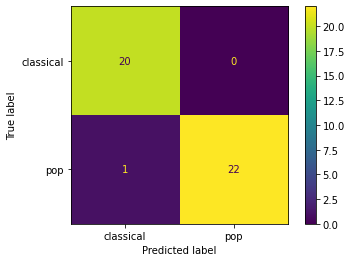

In [89]:
evaluate(train(preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv')), 'COMP30027_2023_asst1_data/pop_vs_classical_test.csv')

              precision    recall  f1-score   support

       blues       0.43      0.16      0.23        19
   classical       0.89      0.85      0.87        20
     country       0.38      0.69      0.49        16
       disco       0.48      0.45      0.47        22
      hiphop       0.50      0.29      0.36        21
        jazz       0.50      0.33      0.40        18
       metal       0.38      0.90      0.54        20
         pop       0.80      0.70      0.74        23
      reggae       0.56      0.64      0.60        14
        rock       0.18      0.11      0.14        27

    accuracy                           0.49       200
   macro avg       0.51      0.51      0.48       200
weighted avg       0.50      0.49      0.47       200



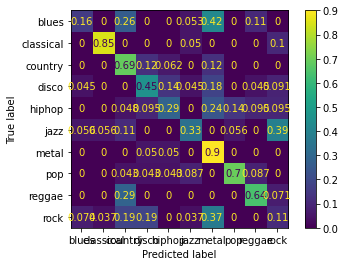

In [42]:
evaluate(train(preprocess('COMP30027_2023_asst1_data/gztan_train.csv')), 'COMP30027_2023_asst1_data/gztan_test.csv')

In [ ]:
import sklearn.naive_bayes as nb
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
train_data = preprocess('COMP30027_2023_asst1_data/gztan_train.csv')
test_data = preprocess('COMP30027_2023_asst1_data/gztan_test.csv')
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']

X_test = test_data.drop(columns=['label'])
y_test = test_data['label']
gnb.fit(X_train, y_train)

acc = gnb.score(X_test, y_test)
print("accuracy:", acc)

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [90]:
def evaluate_pop_classical(model, test_data, true_labels=None):
    test_data = preprocess(test_data)
    if true_labels is None:
        true_labels = test_data['label'].to_list()

    results = predict(model, test_data)
    print("true_labels:", true_labels)
    print("results:", results)

    # consider classical as the positive class
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(results)):
        if results[i] == 'classical' and true_labels[i] == 'classical':
            tp += 1
        elif results[i] == 'classical' and true_labels[i] == 'pop':
            fp += 1
        elif results[i] == 'pop' and true_labels[i] == 'pop':
            tn += 1
        elif results[i] == 'pop' and true_labels[i] == 'classical':
            fn += 1

    # calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # calculate precision
    precision = tp / (tp + fp)
    # calculate recall
    recall = tp / (tp + fn)
    f1 = f1_score(true_labels, results, average='macro')

    cm = confusion_matrix(true_labels, results)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.keys())
    disp.plot()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

true_labels: ['classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop']
results: ['classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'pop', 'pop', 'classical', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop', 'pop']


{'accuracy': 0.9767441860465116,
 'precision': 0.9523809523809523,
 'recall': 1.0,
 'f1': 0.9766937669376694}

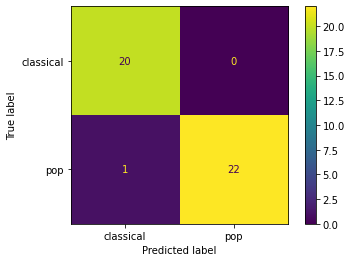

In [91]:
evaluate_pop_classical(train(preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv')), 'COMP30027_2023_asst1_data/pop_vs_classical_test.csv')

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

In [ ]:
def get_domain(data: pd.DataFrame, feature: str, label: str=None):
    if label is not None:
        data = data[data['label'] == label][feature]
    else:
        data = data[feature]

    return data.min(), data.max()

In [81]:
def plot_prob_density(data: pd.DataFrame, model: {}, feature: str, domain: ()=None, title: str=None, x_label: str=None, y_label: str=None):
    for label in data['label'].unique():
        label_mean = model[label]['means'][feature]
        label_sd = model[label]['sd'][feature]
        data_mean = data[feature].mean()
        data_sd = data[feature].std()
        if domain is None:
            x = np.linspace(data_mean-4*data_sd, data_mean+4*data_sd, 50, endpoint=True)
        else:
            x = np.linspace(domain[0], domain[1], 50)
        y = []
        for val in x:
            y.append(calc_gaussian_prob(val, label_mean, label_sd))
        plt.plot(x, y)
    plt.legend(data['label'].unique())
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    plt.savefig(f'{title}.png')
    plt.show()

In [82]:
pop_classical_data = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv')
model = train(pop_classical_data)

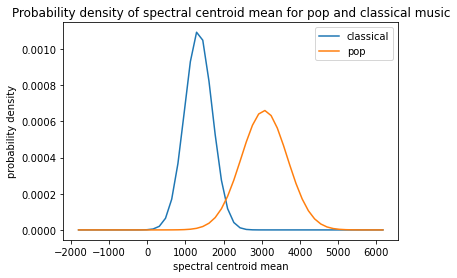

In [83]:
plot_prob_density(pop_classical_data, model, 'spectral_centroid_mean', x_label='spectral centroid mean', y_label='probability density', title='Probability density of spectral centroid mean for pop and classical music')

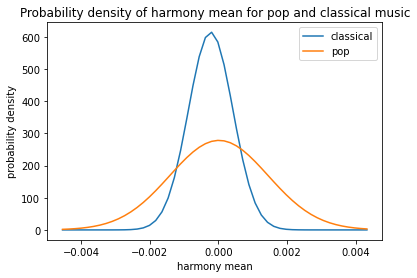

In [84]:
plot_prob_density(pop_classical_data, model, 'harmony_mean', x_label='harmony mean', y_label='probability density', title='Probability density of harmony mean for pop and classical music')

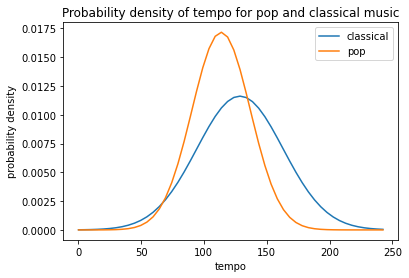

In [85]:
plot_prob_density(pop_classical_data, model, 'tempo', x_label='tempo', y_label='probability density', title='Probability density of tempo for pop and classical music')

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

In [110]:
import warnings
warnings.filterwarnings('once')

In [79]:
from sklearn.model_selection import KFold
import time
# combine test.csv and train.csv
train_data = preprocess('COMP30027_2023_asst1_data/gztan_train.csv')
test_data = preprocess('COMP30027_2023_asst1_data/gztan_test.csv')
data = pd.concat([train_data, test_data])
# data = shuffle(data)

k = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
k_accuracy, k_recall, k_precision = {}, {}, {}
k_run_time = {}
for fold in k:
    kf = KFold(n_splits=fold, shuffle=True, random_state=3)
    accuracy, recall, precision = [], [], []
    run_time = []
    print(f"fold: {fold}")
    start_time = time.time()
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        model = train(train_data)
        results = predict(model, test_data)
        accuracy.append(accuracy_score(test_data['label'].to_list(), results))
        recall.append(recall_score(test_data['label'].to_list(), results, average='weighted'))
        precision.append(precision_score(test_data['label'].to_list(), results, average='weighted'))
        # print(classification_report(test_data['label'].to_list(), results))
    end_time = time.time()
    k_accuracy[fold] = np.array(accuracy).mean()
    k_recall[fold] = np.array(recall).mean()
    k_precision[fold] = np.array(precision).mean()
    k_run_time[fold] = end_time - start_time


print(k_accuracy)
print(k_recall)
print(k_precision)
print(k_run_time)

fold: 2
fold: 5
fold: 10
fold: 20
fold: 50
fold: 100
fold: 200
fold: 500
fold: 1000
{2: 0.518, 5: 0.526, 10: 0.5269999999999999, 20: 0.527, 50: 0.528, 100: 0.53, 200: 0.528, 500: 0.528, 1000: 0.528}
{2: 0.518, 5: 0.526, 10: 0.5269999999999999, 20: 0.527, 50: 0.528, 100: 0.53, 200: 0.528, 500: 0.528, 1000: 0.528}
{2: 0.5313646833221246, 5: 0.5483630792113587, 10: 0.5593537511124851, 20: 0.5593453352203351, 50: 0.6124857142857143, 100: 0.6002833333333334, 200: 0.5815833333333333, 500: 0.5405, 1000: 0.528}
{2: 2.9389548301696777, 5: 2.7585742473602295, 10: 2.938375949859619, 20: 3.556851625442505, 50: 4.262585163116455, 100: 5.272793769836426, 200: 7.296767950057983, 500: 13.873922348022461, 1000: 26.392573833465576}


In [86]:
def plot_bar_chart(k_res: {}, title: str=None, x_label: str=None, y_label: str=None, ylim: ()=None):
    x = [str(i) for i in k_res.keys()]
    y = list(k_res.values())

    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid()
    plt.bar(x, y)

    plt.savefig(f'{title}.png')
    plt.show()

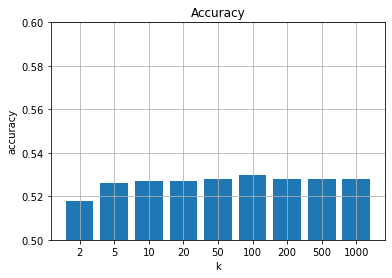

In [76]:
plot_bar_chart(k_accuracy, title='Accuracy with different k values', x_label='k', y_label='accuracy', ylim=(0.5, 0.6))

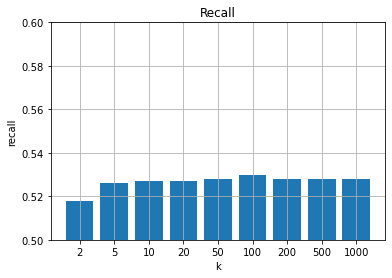

In [77]:
plot_bar_chart(k_recall, title='Recall with different k values', x_label='k', y_label='recall', ylim=(0.5, 0.6))

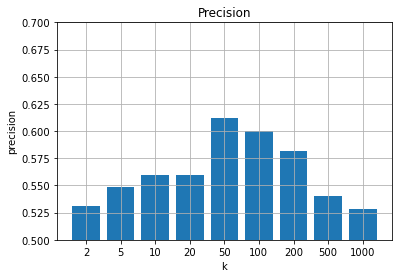

In [78]:
plot_bar_chart(k_precision, title='Precision with different k values', x_label='k', y_label='precision', ylim=(0.5, 0.7))

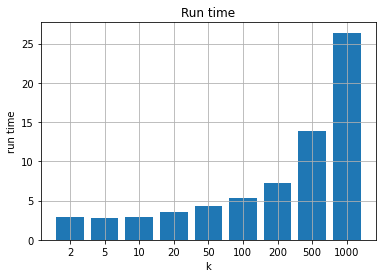

In [80]:
plot_bar_chart(k_run_time, title='Run time in each k values', x_label='k', y_label='run time')

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [180]:
import random

# use a fixed seed to generate reproducible results
# this seed is chosen to avoid cases that all the features are missing but with a label, which is not realistic; please don't change it
rand = random.Random(7)

train_data = preprocess('COMP30027_2023_asst1_data/gztan_train.csv')
model = train(train_data)

test_data = preprocess('COMP30027_2023_asst1_data/gztan_test.csv')
y_ture = test_data['label'].to_list()

amount = np.arange(0, 1, 0.1) #  emulate missing data from 0% to 90%


accuracy, recall, precision = {}, {}, {}

for i in amount:
    temp = test_data.copy()
    for index, row in test_data.iterrows():
        for feature in row.keys():
            if feature == 'label':
                continue
            if rand.random() < i:
                temp.at[index, feature] = False  # use false to denote missing data

    y_pred = predict(model, temp)

    accuracy[round(i, 1)] = round(accuracy_score(y_ture, y_pred), 4)
    recall[round(i, 1)] = round(recall_score(y_ture, y_pred, average='macro'), 4)
    precision[round(i, 1)] = round(precision_score(y_ture, y_pred, average='macro'), 4)


print(accuracy)
print(recall)
print(precision)

{0.0: 0.495, 0.1: 0.5, 0.2: 0.49, 0.3: 0.51, 0.4: 0.505, 0.5: 0.475, 0.6: 0.475, 0.7: 0.445, 0.8: 0.4, 0.9: 0.385}
{0.0: 0.5119, 0.1: 0.5127, 0.2: 0.5038, 0.3: 0.523, 0.4: 0.5175, 0.5: 0.4838, 0.6: 0.4877, 0.7: 0.4571, 0.8: 0.4068, 0.9: 0.3944}
{0.0: 0.5101, 0.1: 0.5167, 0.2: 0.5115, 0.3: 0.557, 0.4: 0.5275, 0.5: 0.4887, 0.6: 0.4789, 0.7: 0.4392, 0.8: 0.3918, 0.9: 0.3991}


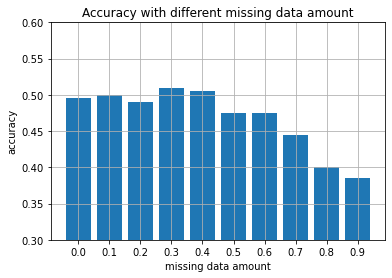

In [181]:
plot_bar_chart(accuracy, title='Accuracy with different missing data amount', x_label='missing data amount', y_label='accuracy', ylim=(0.3, 0.6))

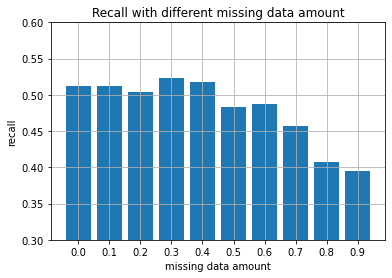

In [182]:
plot_bar_chart(recall, title='Recall with different missing data amount', x_label='missing data amount', y_label='recall', ylim=(0.3, 0.6))

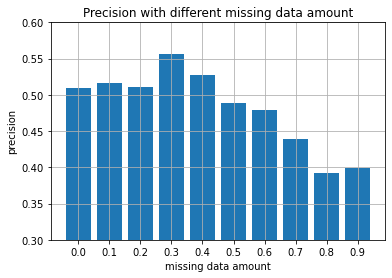

In [183]:
plot_bar_chart(precision, title='Precision with different missing data amount', x_label='missing data amount', y_label='precision', ylim=(0.3, 0.6))